In this first part, we install import all the packages used

In [1]:
#Packages
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Subpackages
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix


#ImportFunctions
from Functions import fetch_data
from Functions import moving_average
from Functions import rsi
from Functions import macd
from Functions import lagged_return
from Functions import bollinger_bands
from Functions import pe_ratio
from Functions import daily_returns






Next, we import some stock data

In [2]:
tickers = ['TSLA', 'AAPL', 'AMZN', 'GOOGL', 'AMD', 'GOOG', 'XOM', 'LLY', 'IBM', 'BAC', 'ADBE', 'HES', 'COST', 'ALGN', 'F', 'DIS', 'ANET', 'MO', 'AMT', 'HD', 'HON', 'ABBV', 'GE', 'ACN', 'ENPH', 'COP', 'AMAT', 'FDX', 'DHR', 'EW', 'GM', 'ABT', 'T', 'AMGN', 'ABNB', 'GS', 'HSY', 'ADP', 'ADI', 'DXCM', 'DG', 'AXP', 'EQIX', 'FI', 'GIS', 'AAL', 'CSX', 'FANG', 'DE', 'CVS', 'DLR', 'EMR', 'ADSK', 'GD', 'HAS', 'AZO', 'GILD', 'HUM', 'CCI', 'FCX', 'HCA', 'MMM', 'AON', 'HAL', 'ETN', 'BKR', 'APH', 'DAL', 'HLT', 'AMP', 'IDXX', 'CTRA', 'ALB', 'FTNT', 'EQT', 'ELV', 'EOG', 'DOW', 'ITW', 'D', 'AJG', 'EXC', 'EXPE', 'DUK', 'DLTR', 'FICO', 'DVN', 'GPN', 'EG', 'ETSY', 'AEP', 'DHI', 'HPQ', 'ADM', 'ALL', 'EBAY', 'AVB', 'EL', 'GEHC', 'IEX']

start_date = "2013-10-01"
end_date = "2023-10-01"

stock_data = fetch_data(tickers, start_date, end_date)

Now we calculate the technical indicators for each stock

In [3]:
# For each stock's data, compute the technical indicators and add them as new columns to the DataFrame

for ticker, data in stock_data.items():
    # Backup the 'Close' prices
    close_prices = data['Close'].copy()
    
    # 20-day Moving Average
    data['MA20'] = moving_average(data)
    
    # RSI
    data['RSI'] = rsi(data)
    
    # MACD
    data['MACD'], data['Signal_Line'] = macd(data)
    
    # 1, 2, and 3 Day Lagged Returns
    data['Lagged_Return_1'] = lagged_return(data, 1)
    data['Lagged_Return_2'] = lagged_return(data, 2)
    data['Lagged_Return_3'] = lagged_return(data, 3)
    
    # Bollinger Bands
    data['Upper_Bollinger'], data['Lower_Bollinger'] = bollinger_bands(data)
    
    # Restore 'Close' column
    data['Close'] = close_prices

    # Extract the 'Close' column
    close_prices = data['Close']
    
    # Calculate daily returns for all available days
    daily_returns = close_prices.pct_change().dropna()

    



Now that we have all the technical indicators for each stock we make a new dataframe that contains the data for all the stocks. We also do some data cleaning like removing the NANs.

In [4]:
# Dictionary to store the split data for each stock
all_stock_data = {}

for ticker, data in stock_data.items():
    data_clean = data.dropna()  # drop rows with NaN values
    
    # Check if the cleaned data has a minimum number of rows
    if len(data_clean) < 10:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    # Features: using technical indicators and lagged returns
    X = data_clean[['RSI', 'MACD', 'Signal_Line', 'Lagged_Return_1', 'Lagged_Return_2', 'Lagged_Return_3', 'Upper_Bollinger', 'Lower_Bollinger']]

    # Target: Direction of the next day's return (1 for positive, 0 for negative or non-positive)
    y = (data_clean['Close'].pct_change().shift(-1) > 0).astype(int)

    # Splitting the data: 70% train, 15% validation, 15% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)
    
    # Store the data splits in the dictionary
    all_stock_data[ticker] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

# Now, `all_stock_data` contains the data splits for all stocks.


Now we actually make the classifier to predict the stock direction. We use a random forest model to determine this.

In [9]:
# Initialize the list to store results
stock_results_HOLD = []

# Keep track of the current index in all_X_test and all_y_test
current_idx = 0

# Loop through each ticker to extract predictions and actual returns
for ticker in all_stock_data:
    
    # Calculate the actual daily return for the stock
    # Access the 'Close' column directly from the original stock_data
    daily_returns = stock_data[ticker].loc[all_stock_data[ticker]['X_test'].index]['Close'].pct_change().shift(-1).dropna()
    
    # Append the results to the stock_results list
    stock_results_HOLD.append({
        'Ticker': ticker,
        'Actual Daily Returns': daily_returns.values
    })

    # Update the current index for the next iteration
    current_idx += num_samples

# Now, the stock_results list contains the predictions from both models and the actual daily returns for each stock.


We perform the backtest and plot the results

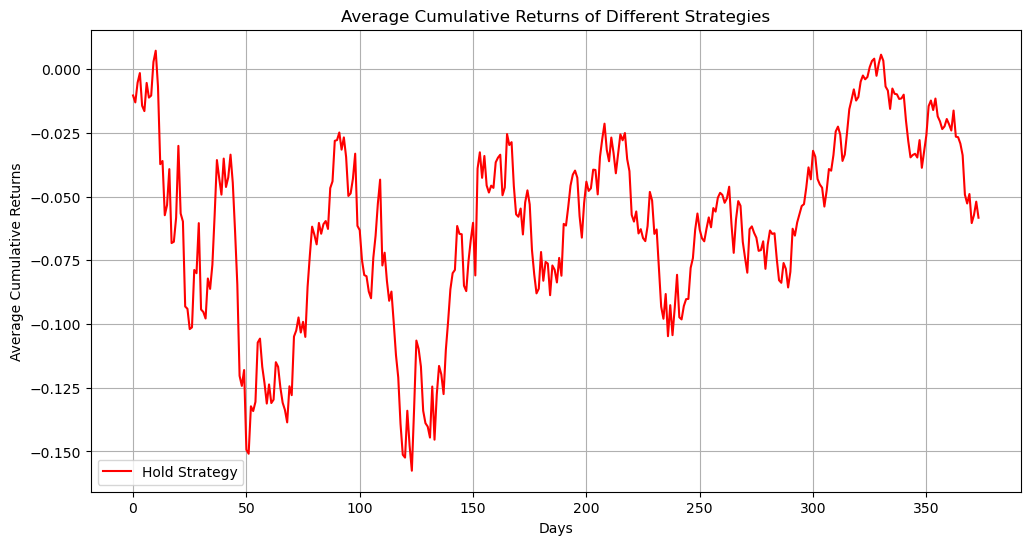

In [10]:
# Initialize lists to store cumulative returns for each strategy
cumulative_returns_hold = []

for result in stock_results_HOLD:
    # Extract only the required number of predictions equal to the length of actual daily returns
    actual_daily_returns = result['Actual Daily Returns']
    
    # Calculate the cumulative returns
    cumulative_returns_hold.append((1 + actual_daily_returns).cumprod() - 1)

# Calculate the mean cumulative returns across all stocks for each day
mean_cumulative_returns_hold = np.nanmean(np.array([np.pad(cr, (0, max(map(len, cumulative_returns_hold)) - len(cr)), 'edge') for cr in cumulative_returns_hold]), axis=0)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(mean_cumulative_returns_hold, label="Hold Strategy", color='red')
plt.title("Average Cumulative Returns of Different Strategies")
plt.xlabel("Days")
plt.ylabel("Average Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()
